<a href="https://www.kaggle.com/code/swish9/weather-image-recognition-model?scriptVersionId=184435713" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #87CEEB; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🌦️ Introduction
</div>

**This notebook explores the task of weather image classification using deep learning techniques. The dataset used for this project is sourced from Kaggle, containing 6862 images categorized into 11 different weather classes including dew, fog/smog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, and snow. The goal is to develop and compare multiple models for weather classification: starting with a custom convolutional neural network (CNN), followed by fine-tuning popular pre-trained models such as VGG16, ResNet50, and DenseNet using TensorFlow and other essential libraries. The project aims to achieve robust classification performance through both custom model architecture and leveraging transfer learning techniques.**

<div style="background-color: #4682B4; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  📚 Importing Libraries and Data
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing and visualization
from PIL import Image
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn forpreprocessing and  metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

2024-06-19 19:39:33.021534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 19:39:33.021672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 19:39:33.136225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = '/kaggle/input/weather-dataset/dataset'

batch_size = 32
img_height = 128
img_width = 128

In [4]:
dataset = image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    verbose=True,
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

Found 6862 files belonging to 11 classes.


<div style="background-color: #1E90FF; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔍 Exploratory Data Analysis (EDA)
</div>

In [5]:
class_images = {class_name: [] for class_name in dataset.class_names}

In [6]:
for images, labels in dataset.take(len(dataset)):
    for img, label in zip(images, labels):
        class_name = dataset.class_names[label]
        if len(class_images[class_name]) < 8:
            class_images[class_name].append(img)
        if all(len(imgs) == 8 for imgs in class_images.values()):
            break
    if all(len(imgs) == 8 for imgs in class_images.values()):
        break

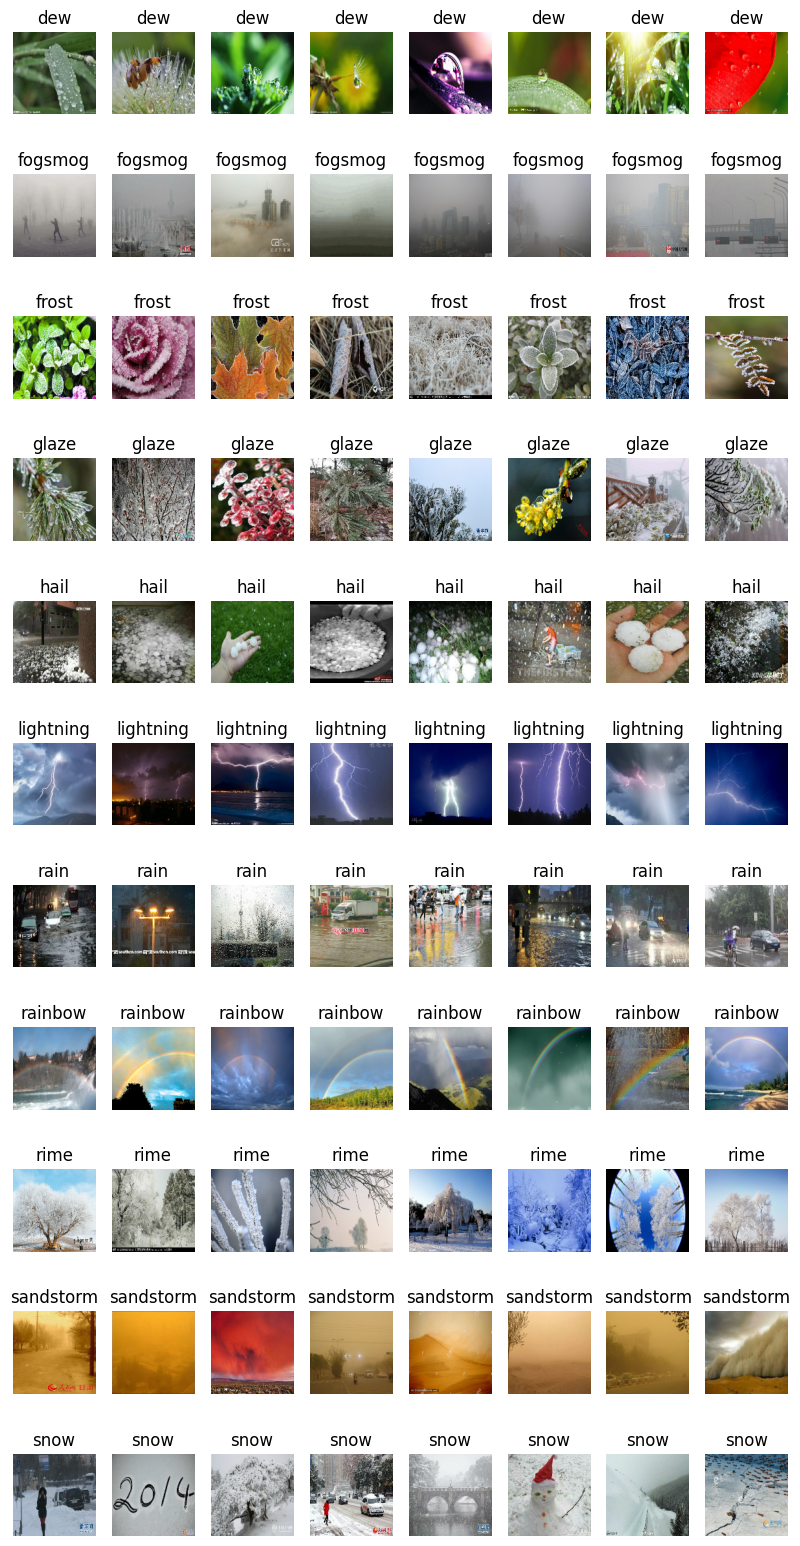

In [7]:
plt.figure(figsize=(10, 20))
i = 0
for class_name, images in class_images.items():
    for img in images:
        i += 1
        plt.subplot(len(dataset.class_names), 8, i)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis('off')
plt.show()

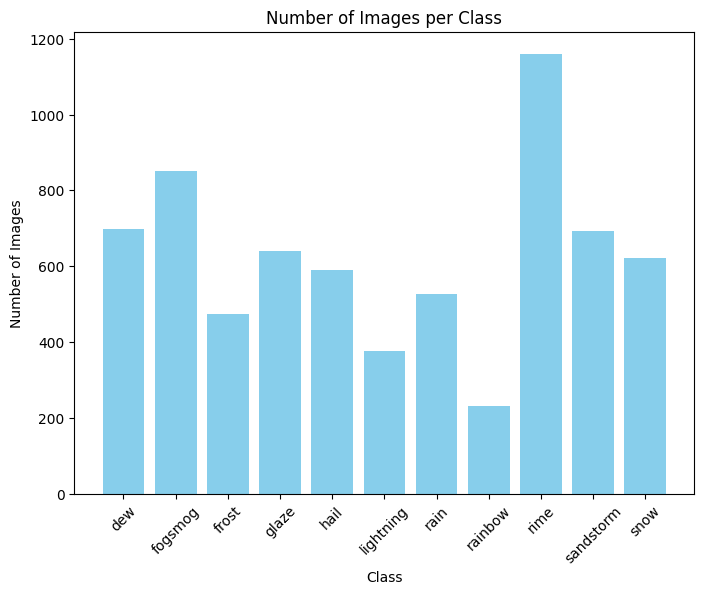

In [8]:
class_counts = {class_name: 0 for class_name in dataset.class_names}
for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Bar plot of image counts per class
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

> Dataset Seems to be highly imbalanced 

In [9]:
def extract_color_histograms(images):
    red_hist = []
    green_hist = []
    blue_hist = []

    for image in images:
        image = image.numpy().astype(np.uint8)
        
        hist_red = np.histogram(image[:,:,0], bins=256, range=[0, 256])[0]
        hist_green = np.histogram(image[:,:,1], bins=256, range=[0, 256])[0]
        hist_blue = np.histogram(image[:,:,2], bins=256, range=[0, 256])[0]
        
        red_hist.append(hist_red)
        green_hist.append(hist_green)
        blue_hist.append(hist_blue)
    
    return red_hist, green_hist, blue_hist

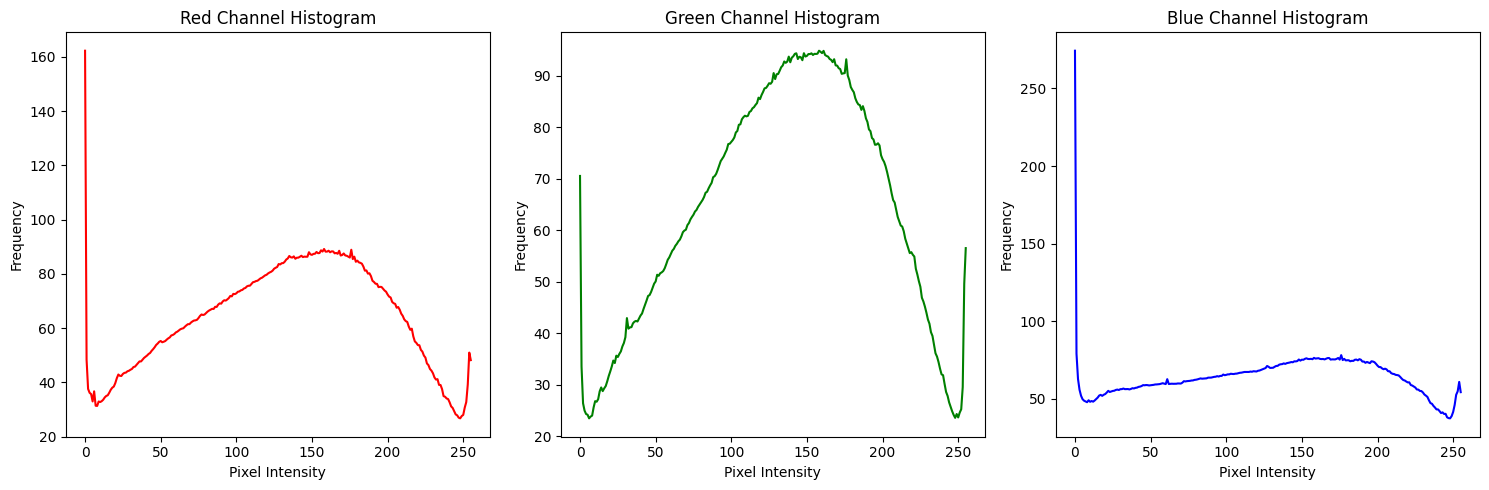

In [10]:
red_histograms = []
green_histograms = []
blue_histograms = []

for images, labels in dataset:
    red_hist, green_hist, blue_hist = extract_color_histograms(images)
    red_histograms.extend(red_hist)
    green_histograms.extend(green_hist)
    blue_histograms.extend(blue_hist)

# Plotting color histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Red Channel Histogram')
plt.plot(np.mean(red_histograms, axis=0), color='red')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.title('Green Channel Histogram')
plt.plot(np.mean(green_histograms, axis=0), color='green')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.title('Blue Channel Histogram')
plt.plot(np.mean(blue_histograms, axis=0), color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
def calculate_image_metrics(image):
    image = image.numpy().astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    brightness = np.mean(gray)
    
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    sharpness = laplacian
    
    return brightness, sharpness

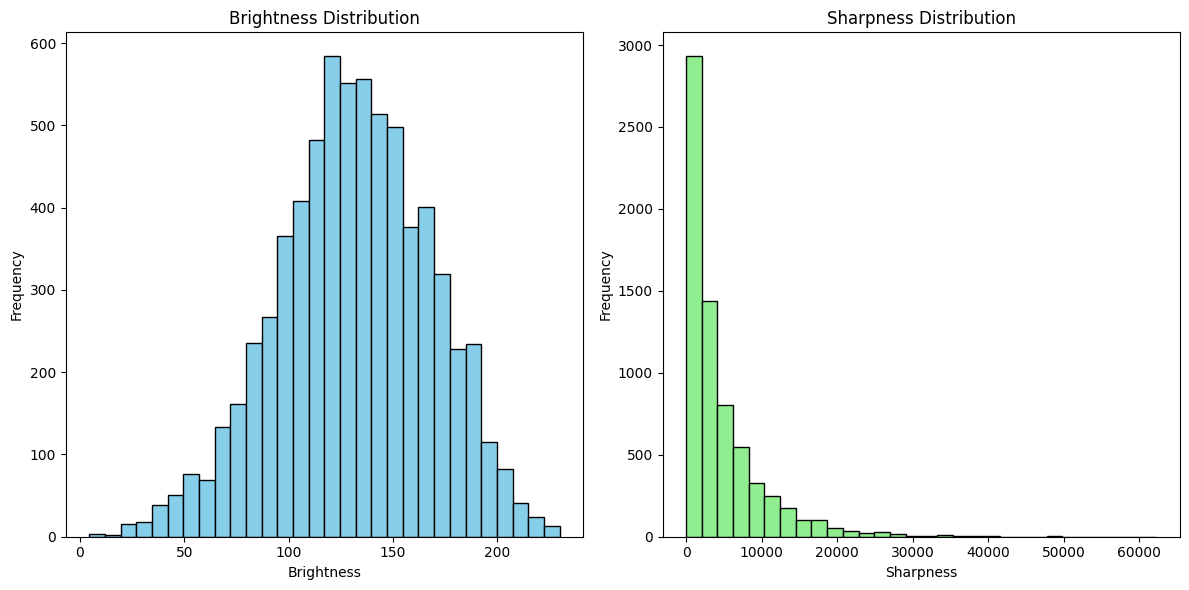

In [12]:
brightness_values = []
sharpness_values = []

for images, labels in dataset:
    for image in images:
        brightness, sharpness = calculate_image_metrics(image)
        brightness_values.append(brightness)
        sharpness_values.append(sharpness)

# Plotting image quality metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(brightness_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sharpness_values, bins=30, color='lightgreen', edgecolor='black')
plt.title('Sharpness Distribution')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<div style="background-color: #00BFFF; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  ⚙️ Preprocessing
</div>

> **I believe class imbalance can be tackled by finding class weights**

In [13]:
labels = []
for image, label in dataset:
    labels.extend(label.numpy())
labels = np.array(labels)
labels = labels.astype(int)  
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:
num_classes = 11
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_dataset = val_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [15]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

def preprocess_image(image, label):
    image = data_augmentation(image)
    image = Rescaling(1./255)(image)  
    return image, label

In [16]:
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<div style="background-color: #00CED1; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🛠️ Custom Model
</div>

In [17]:
def add_block_1(model, first_block=False, initializer=HeNormal()):
    if first_block:
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3), kernel_initializer=initializer))
    else:
        model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

def add_block_2(model, initializer=HeNormal()):
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

def add_block_3(model, initializer=HeNormal()):
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

In [18]:
my_model = Sequential()

# Convolutional blocks
add_block_1(my_model, first_block=True)
add_block_2(my_model)
add_block_1(my_model)
add_block_2(my_model)
add_block_3(my_model)
add_block_3(my_model)
add_block_3(my_model)

# Flatten the output to feed into dense layers
my_model.add(Flatten())

# Fully connected layers with initialized weights
initializer = HeNormal()
my_model.add(Dense(512, activation='relu', kernel_initializer=initializer))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation='relu', kernel_initializer=initializer))
my_model.add(Dropout(0.5))
my_model.add(Dense(128, activation='relu', kernel_initializer=initializer))
my_model.add(Dropout(0.5))
my_model.add(Dense(11, activation='softmax', kernel_initializer=initializer))

my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

my_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 64, 64, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 32, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         9,24

 Total params: 1,585,451 (6.05 MB)

 Trainable params: 1,582,507 (6.04 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [21]:
history = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50, 
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5628 - loss: 1.3425 - val_accuracy: 0.5169 - val_loss: 1.3724
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.5640 - loss: 1.3402 - val_accuracy: 0.5022 - val_loss: 1.4787
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.5556 - loss: 1.3418 - val_accuracy: 0.4890 - val_loss: 1.4827
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.5572 - loss: 1.3557 - val_accuracy: 0.4750 - val_loss: 1.5468
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.5500 - loss: 1.3411 - val_accuracy: 0.5405 - val_loss: 1.3171
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.5842 - loss: 1.2984 - val_accuracy: 0.5538 - val_loss: 1.2868
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5776 - loss: 1.2701 - val_accuracy: 0.5007 - val_loss: 1.4099
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5777 - loss: 1

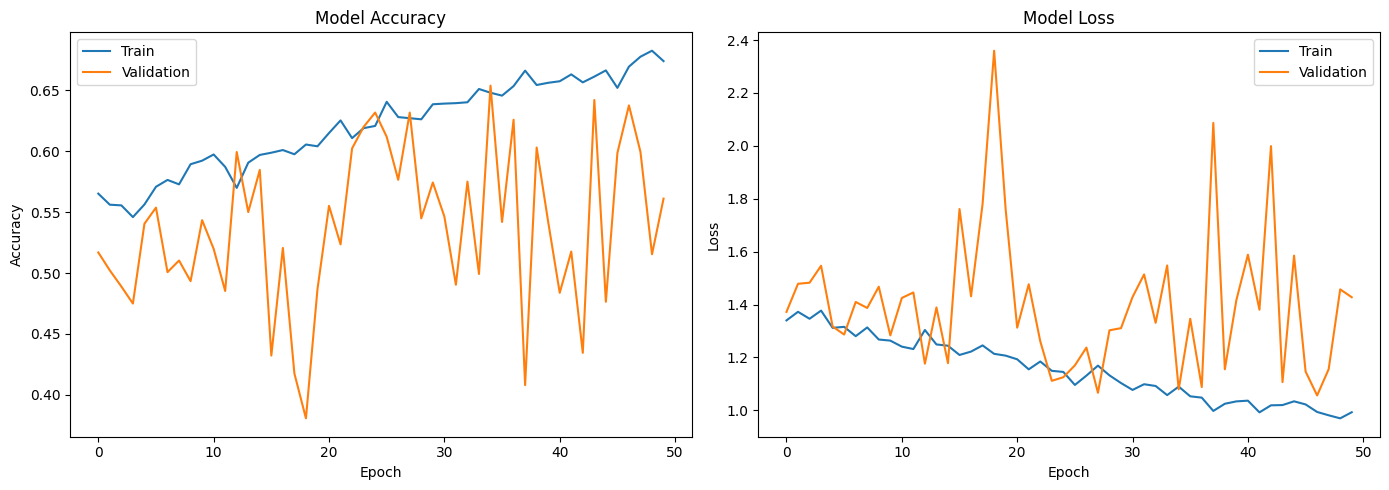

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<div style="background-color: #20B2AA; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔧 Fine-Tuning
</div>

In [22]:
def add_block_1(model, first_block=False, initializer=HeNormal()):
    if first_block:
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3), kernel_initializer=initializer))
    else:
        model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

def add_block_2(model, initializer=HeNormal()):
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))

def add_block_3(model, initializer=HeNormal()):
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

In [24]:
def swish_activation(x):
    return x * tf.sigmoid(x)

In [30]:
my_model2 = Sequential()
add_block_1(my_model2, first_block=True)
add_block_2(my_model2)
add_block_1(my_model2)
add_block_2(my_model2)
add_block_3(my_model2)
add_block_3(my_model2)
add_block_3(my_model2)


my_model2.add(Flatten())
initializer = HeNormal()
my_model2.add(Dense(512, activation=swish_activation, kernel_initializer=initializer))
my_model2.add(Dropout(0.5))
my_model2.add(Dense(256, activation=swish_activation, kernel_initializer=initializer))
my_model2.add(Dropout(0.5))
my_model2.add(Dense(128, activation=swish_activation, kernel_initializer=initializer))
my_model2.add(Dropout(0.5))

my_model2.add(Dense(11, activation='softmax', kernel_initializer=initializer))

my_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
my_model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_16            │ (None, 64, 64, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 32, 32, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 32, 32, 32)     │         9,24

 Total params: 1,585,451 (6.05 MB)

 Trainable params: 1,582,507 (6.04 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [31]:
history = my_model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50, 
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.1545 - loss: 3.8574 - val_accuracy: 0.3284 - val_loss: 1.9443
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.3051 - loss: 2.1924 - val_accuracy: 0.3608 - val_loss: 1.7650
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.3987 - loss: 1.8213 - val_accuracy: 0.4654 - val_loss: 1.5846
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.4149 - loss: 1.7465 - val_accuracy: 0.3748 - val_loss: 1.6827
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4460 - loss: 1.6473 - val_accuracy: 0.4566 - val_loss: 1.4921
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.4779 - loss: 1.5834 - val_accuracy: 0.5471 - val_loss: 1.3371
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.4930 - loss: 1.5631 - val_accuracy: 0.5442 - val_loss: 1.3580
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5102 - loss: 1

KeyboardInterrupt: 

<div style="background-color: #5F9EA0; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔄 Transfer Learning
</div>

<div style="background-color: #4682B4; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  📊 Comparison and Evaluation
</div>

<div style="background-color: #4169E1; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🏁 Conclusion
</div>